In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = matplotlib.colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

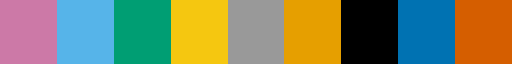

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_k562 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_K562.tsv", sep="\t")

In [7]:
chip_atlas_k562.head()

,tf,Target_genes
0,ADNP,TRMT2A
1,ADNP,RANBP1
2,ADNP,OSCAR
3,ADNP,NDUFA3
4,ADNP,PSMD9


In [8]:
k562 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_K562_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

k562 = k562.loc[k562.is_M2Kb & (k562.is_pls | k562.is_pels | k562.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
k562 = k562.loc[k562.tf.isin(collectri.source) & k562.tf.isin(chip_atlas_k562.tf)]

/scratch/47227602/ipykernel_10716/969444568.py:1: DtypeWarning: Columns (49,51,53,54) have mixed types. Specify dtype option on import or set low_memory=False.


In [9]:
chip_atlas_k562 = chip_atlas_k562.loc[chip_atlas_k562.tf.isin(k562.tf)]
chip_atlas_k562["weight"] = 1
k562["weight"] = 1

In [10]:
collectri = collectri[collectri.source.isin(k562.tf)]

### Prepare cosmic

In [11]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# AML integrated dataset

### C6 vs other leukemic cells

In [12]:
data = pd.read_csv("../data/case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Takao & Kentsis LRC,Metadata: Velten
Gene,,,,,,,,
AREG,7,0,"2,3179424781",1,44,7,NaN,Other
FOS,7,0,"2,0089384569",1,42,7,NaN,AP1 factors
FTH1,7,0,"1,2502755149",1,60,7,NaN,Erythromyeloid priming
SLC40A1,7,0,"1,2451559941",1,47,7,1.0,Erythromyeloid priming
CD69,6,0,"1,0858648734",1,39,6,NaN,Other
...,...,...,...,...,...,...,...,...
YPEL3,1,1,"0,0845519869",0,15,0,NaN,Other
YWHAZ,1,1,"0,0008226982",0,7,0,NaN,Erythromyeloid priming
ZEB2,2,2,"-0,1924227130",1,26,0,-1.0,Other


In [13]:
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = - de_genes["Mean log2 Fold Change"]
#de_genes = de_genes[de_genes["Mean log2 Fold Change"].abs() > 1]

In [14]:
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
AREG,2.317942,-2.317942
FOS,2.008938,-2.008938
FTH1,1.250276,-1.250276
SLC40A1,1.245156,-1.245156
CD69,1.085865,-1.085865
...,...,...
ZSCAN18,0.277256,-0.277256
ZSCAN26,0.920350,-0.920350
ZSWIM6,0.433205,-0.433205


In [15]:
de_genes.describe()

,Mean log2 Fold Change,leukemic
count,3185.000000,3185.000000
mean,0.173994,-0.173994
std,0.591406,0.591406
min,-2.251899,-2.651443
25%,-0.344875,-0.542822
50%,0.329855,-0.329855
75%,0.542822,0.344875
max,2.651443,2.251899


In [16]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET")
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Leukemia, Myelocytic, Acute",446/1703,4.340686e-30,3.762073e-26,0,0,2.015400,136.260247,RB1;CDA;CHIC2;SPI1;TFRC;BACH1;GLS;GJA1;HOXA9;M...
1,DisGeNET,leukemia,491/1941,2.413857e-29,1.046045e-25,0,0,1.931294,127.260209,RB1;CDA;CHIC2;SPI1;RNH1;TFRC;EHMT1;SMC4;GLS;SM...
2,DisGeNET,Acute lymphocytic leukemia,265/907,4.159066e-25,1.201554e-21,0,0,2.286223,128.347040,RB1;IL1RN;SPI1;GFI1;JMJD1C;IKZF1;ACTB;GLS;LGAL...
3,DisGeNET,Precursor Cell Lymphoblastic Leukemia Lymphoma,192/618,1.124858e-21,2.437286e-18,0,0,2.467956,119.045868,RB1;IL1RN;CSF1;IRS1;MPG;GFI1;ATN1;F13A1;SLA;JM...
4,DisGeNET,"Liver Cirrhosis, Experimental",227/801,8.673278e-20,1.503426e-16,0,0,2.171344,95.303432,IFITM1;WIPF1;GMFG;ICAM2;ZDHHC2;GLS;SMC2;LGALS3...
...,...,...,...,...,...,...,...,...,...,...
8662,DisGeNET,Ragged-red muscle fibers,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,TYMP
8663,DisGeNET,Rat Adrenal Gland Pheochromocytoma,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,BCL2L1
8664,DisGeNET,Retinal Dystrophies,14/178,9.995380e-01,9.997687e-01,0,0,0.448258,0.000207,PEX16;HGSNAT;PRPS1;GRN;SUCNR1;TRAF3IP1;PRPF8;T...
8665,DisGeNET,Syndactyly,4/85,9.996806e-01,9.997960e-01,0,0,0.259783,0.000083,GJA1;NOG;LMNA;ZSWIM6


In [17]:
de_genes.drop("Mean log2 Fold Change", axis=1, inplace=True)

In [18]:
de_genes = de_genes.T

In [19]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
7924,NONO,RBFOX2,-0.1903
9734,GTF2B,RBFOX2,-0.1658
11104,FUS,RBFOX2,-0.1493
12553,E2F1,GATAD2B,-0.1332
12612,ELF4,GATAD2B,-0.1325
...,...,...,...
4,DLX4,ZNF174,0.6143
3,CREM,NEUROD1,0.6224
2,JUND,NEUROD1,0.6382
1,CREM,JUND,0.7055


In [20]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
3726,MYC,SREBF1,-0.0648
4163,MYC,NCOR1,-0.0537
4354,MYC,TEAD1,-0.0493
4364,E2F6,SP1,-0.0491
4469,ESRRA,TP53,-0.0459
...,...,...,...
4,FOS,JUN,0.4750
3,CTNNB1,TCF7L2,0.5005
2,NFYA,NFYB,0.5345
1,SMAD2,SMAD3,0.5476


In [21]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [22]:
de_genes

Gene,AREG,FOS,FTH1,SLC40A1,CD69,CD99,CRIP1,FCER1A,LST1,VIM,...,ZNRF1,ZNRF3,ZPR1,ZRANB2,ZSCAN16-AS1,ZSCAN18,ZSCAN26,ZSWIM6,ZXDA,ZYX
leukemic,-2.317942,-2.008938,-1.250276,-1.245156,-1.085865,1.146033,1.660485,-1.716856,0.68972,1.063622,...,-0.666956,-0.495611,-0.302954,-0.565215,0.624069,-0.277256,-0.92035,-0.433205,-0.862397,0.539054


K562

In [23]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [24]:
mask = tf_pvals_k562 < 0.05
active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [25]:
active_tfs_k562

['ATF1',
 'ATF2',
 'BHLHE40',
 'CC2D1A',
 'CREB1',
 'CTCF',
 'E2F1',
 'ETS1',
 'FOXM1',
 'GATA2',
 'HDAC1',
 'IRF1',
 'KAT2B',
 'KLF16',
 'MNT',
 'NFATC3',
 'NR3C1',
 'PHF8',
 'PLAG1',
 'PML',
 'REST',
 'SAP30',
 'SIN3A',
 'TRIM28',
 'ZBTB7A',
 'ZNF77']

In [26]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_k562_activity_m2kb.tsv", sep="\t", index=False)

In [27]:
out_k562.sort_values("p_value")

,score,p_value
PHF8,-2.682597,0.007343
PLAG1,-2.665130,0.007735
CC2D1A,-2.640053,0.008330
E2F1,-2.593962,0.009531
TRIM28,-2.587372,0.009715
...,...,...
MXI1,-0.032668,0.973942
ZNF239,-0.024255,0.980651
ZNF79,-0.019604,0.984360
LEF1,0.005880,0.995309


In [28]:
active_tfs_k562

['ATF1',
 'ATF2',
 'BHLHE40',
 'CC2D1A',
 'CREB1',
 'CTCF',
 'E2F1',
 'ETS1',
 'FOXM1',
 'GATA2',
 'HDAC1',
 'IRF1',
 'KAT2B',
 'KLF16',
 'MNT',
 'NFATC3',
 'NR3C1',
 'PHF8',
 'PLAG1',
 'PML',
 'REST',
 'SAP30',
 'SIN3A',
 'TRIM28',
 'ZBTB7A',
 'ZNF77']

In [29]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [30]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [31]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [32]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,-0.615055,0.538562,M2Kb_K-562
ARHGAP35,-0.786835,0.431437,M2Kb_K-562
ARID1B,0.365251,0.714948,M2Kb_K-562
ARID3A,-1.163573,0.244684,M2Kb_K-562
ARID3B,-0.421457,0.673450,M2Kb_K-562
...,...,...,...
ZNF436,-0.108354,0.913722,M2Kb_K-562
ZNF444,0.622665,0.533549,M2Kb_K-562
ZNF76,0.936015,0.349337,M2Kb_K-562
ZNF77,-2.009989,0.044517,M2Kb_K-562


CollecTri

In [33]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight="weight")
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [34]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

EZH2     -2.955058
NFE2     -2.893968
NFIC     -2.653232
KLF1     -2.627798
E2F1     -2.590117
NFATC3   -2.573544
CREB1    -2.501038
ELK1     -2.460927
GATA2    -2.048440
IRF2      2.034342
NR3C1     2.050395
LEF1      2.165952
IKZF1     2.294379
CREBBP    2.335270
IRF1      2.360886
CTNNB1    2.487155
CREM      2.515737
RFX5      2.920896
HEY1      3.339543
SP1       3.776416
ELF1      3.954784
SPI1      4.202702
Name: leukemic, dtype: float32

In [35]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_k562_activity_collectri.tsv", sep="\t", index=False)

In [36]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [37]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [38]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,"Leukemia, Myelocytic, Acute",15/1703,8.115910e-12,1.262024e-08,0,0,23.218517,592.935797,CREBBP;SPI1;LEF1;IKZF1;GATA2;NR3C1;ELK1;KLF1;E...,CollecTri
1,DisGeNET,leukemia,15/1941,5.343432e-11,4.154518e-08,0,0,20.084557,475.051353,CREBBP;SPI1;LEF1;NFATC3;IKZF1;GATA2;NR3C1;KLF1...,CollecTri
2,DisGeNET,"Lupus Erythematosus, Systemic",12/1113,3.201825e-10,1.659613e-07,0,0,20.574387,449.799919,CREBBP;ELF1;SPI1;CREB1;SP1;IRF1;IRF2;CREM;IKZF...,CollecTri
3,DisGeNET,Central neuroblastoma,13/1655,1.991299e-09,7.729861e-07,0,0,16.129923,323.154596,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri
4,DisGeNET,Neuroblastoma,13/1698,2.729257e-09,7.729861e-07,0,0,15.681438,309.225975,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri
...,...,...,...,...,...,...,...,...,...,...,...
1550,DisGeNET,Arthritis,1/630,5.056562e-01,5.069603e-01,0,0,1.464835,0.998868,NR3C1,CollecTri
1551,DisGeNET,Kidney Diseases,1/639,5.106875e-01,5.116747e-01,0,0,1.443499,0.970028,CREBBP,CollecTri
1552,DisGeNET,Amyotrophic Lateral Sclerosis,1/660,5.222378e-01,5.229104e-01,0,0,1.395982,0.906875,CREBBP,CollecTri
1553,DisGeNET,Liver Cirrhosis,1/683,5.345894e-01,5.349335e-01,0,0,1.347298,0.843754,CTNNB1,CollecTri


In [39]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [40]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,-0.615055,0.538562,M2Kb_K-562
ARHGAP35,-0.786835,0.431437,M2Kb_K-562
ARID1B,0.365251,0.714948,M2Kb_K-562
ARID3A,-1.163573,0.244684,M2Kb_K-562
ARID3B,-0.421457,0.673450,M2Kb_K-562
...,...,...,...
YBX3,0.825308,0.409259,CollecTri
YY1,1.443798,0.148894,CollecTri
ZBED1,-0.299977,0.764214,CollecTri
ZBTB7A,0.377502,0.705826,CollecTri


chip_atlas_k562

In [41]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562 = dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [42]:
tf_pvals_chip_atlas_k562

,ADNP,ARHGAP35,ARID1B,ARID3A,ARID3B,ARNT,ASH1L,ATF1,ATF2,ATF3,...,ZNF274,ZNF281,ZNF316,ZNF384,ZNF395,ZNF436,ZNF444,ZNF76,ZNF77,ZNF79
leukemic,0.474575,0.917271,0.525063,0.127674,0.615401,0.276648,0.995348,0.035705,0.002523,0.1869,...,0.344477,0.145598,0.456509,0.418333,0.110102,0.215864,0.842052,0.702109,0.719365,0.11751


In [43]:
mask_chip_atlas_k562 = tf_pvals_chip_atlas_k562 < 0.05

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask_chip_atlas_k562).sum(axis=0) != 0].index.to_list()

In [44]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas.to_csv("../data/3-tf_activity/aml_k562_activity_ca_k562.tsv", sep="\t", index=False)

In [45]:
active_tfs_chip_atlas_k562

['ATF1',
 'ATF2',
 'ATF7',
 'BCLAF1',
 'BHLHE40',
 'BRD4',
 'CREB1',
 'CREM',
 'E2F1',
 'E2F4',
 'EGR1',
 'ERG',
 'ETS1',
 'FOXJ2',
 'FOXK2',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GMEB1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'IKZF1',
 'IRF1',
 'JUN',
 'JUND',
 'KDM5B',
 'LDB1',
 'MAX',
 'MAZ',
 'MBD2',
 'MNT',
 'MTA3',
 'MYC',
 'NCOR1',
 'PBX2',
 'PHF8',
 'PML',
 'RBFOX2',
 'RCOR1',
 'REST',
 'RREB1',
 'SIN3A',
 'SMAD1',
 'SMAD5',
 'TAF1',
 'TBL1XR1',
 'TBP',
 'TCF12',
 'TCF3',
 'TCF7',
 'TFDP1',
 'UBTF',
 'USF1',
 'YY1',
 'ZBTB12',
 'ZBTB7A',
 'ZFX',
 'ZNF148']

In [46]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [47]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)


In [48]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [49]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,-0.615055,0.538562,M2Kb_K-562
ARHGAP35,-0.786835,0.431437,M2Kb_K-562
ARID1B,0.365251,0.714948,M2Kb_K-562
ARID3A,-1.163573,0.244684,M2Kb_K-562
ARID3B,-0.421457,0.673450,M2Kb_K-562
...,...,...,...
ZNF436,1.237847,0.215864,CA_K-562
ZNF444,0.199285,0.842052,CA_K-562
ZNF76,-0.382510,0.702109,CA_K-562
ZNF77,-0.359340,0.719365,CA_K-562


Plotting results

In [50]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[1], pal[7], pal[2]]

In [51]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,15.000000,15.000000,15.0,15.0,15.000000,15.000000,15.000000
mean,0.008705,0.012848,0.0,0.0,24.916801,214.102890,2.544242
std,0.011561,0.015874,0.0,0.0,14.288651,196.159656,0.995228
min,0.000002,0.000176,0.0,0.0,8.196491,29.524799,1.424112
25%,0.000115,0.000176,0.0,0.0,13.896753,65.439491,1.757114
50%,0.005554,0.008126,0.0,0.0,19.732143,102.472406,2.090116
75%,0.016185,0.022893,0.0,0.0,37.394737,339.086841,3.755152
max,0.027266,0.037661,0.0,0.0,55.974684,737.239944,3.755152


In [52]:
aml_omim_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,OMIM_Expanded,gastric cancer,3/87,0.000192,0.008126,0,0,30.885093,264.271789,CREB1;PLAG1;IRF1,M2Kb_K-562,2.090116
93,OMIM_Expanded,tuberculosis,2/86,0.005554,0.008126,0,0,19.732143,102.472406,CREB1;PLAG1,M2Kb_K-562,2.090116
94,OMIM_Expanded,coronary artery disease,2/87,0.005681,0.008126,0,0,19.499020,100.823792,CREB1;PLAG1,M2Kb_K-562,2.090116
95,OMIM_Expanded,hirschsprung disease,2/87,0.005681,0.008126,0,0,19.499020,100.823792,CREB1;PLAG1,M2Kb_K-562,2.090116
96,OMIM_Expanded,hypotrichosis,2/87,0.005681,0.008126,0,0,19.499020,100.823792,CREB1;PLAG1,M2Kb_K-562,2.090116
0,OMIM_Expanded,bare lymphocyte syndrome,4/83,0.000002,0.000176,0,0,55.974684,737.239944,CREBBP;CREB1;RFX5;CTNNB1,CollecTri,3.755152
93,OMIM_Expanded,tuberculosis,3/86,0.000111,0.000176,0,0,37.847178,344.490631,CREBBP;CREB1;CTNNB1,CollecTri,3.755152
94,OMIM_Expanded,coronary artery disease,3/87,0.000115,0.000176,0,0,37.394737,339.086841,CREBBP;CREB1;CTNNB1,CollecTri,3.755152
95,OMIM_Expanded,hirschsprung disease,3/87,0.000115,0.000176,0,0,37.394737,339.086841,CREBBP;CREB1;CTNNB1,CollecTri,3.755152
96,OMIM_Expanded,hypotrichosis,3/87,0.000115,0.000176,0,0,37.394737,339.086841,CREBBP;CREB1;CTNNB1,CollecTri,3.755152


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562.svg


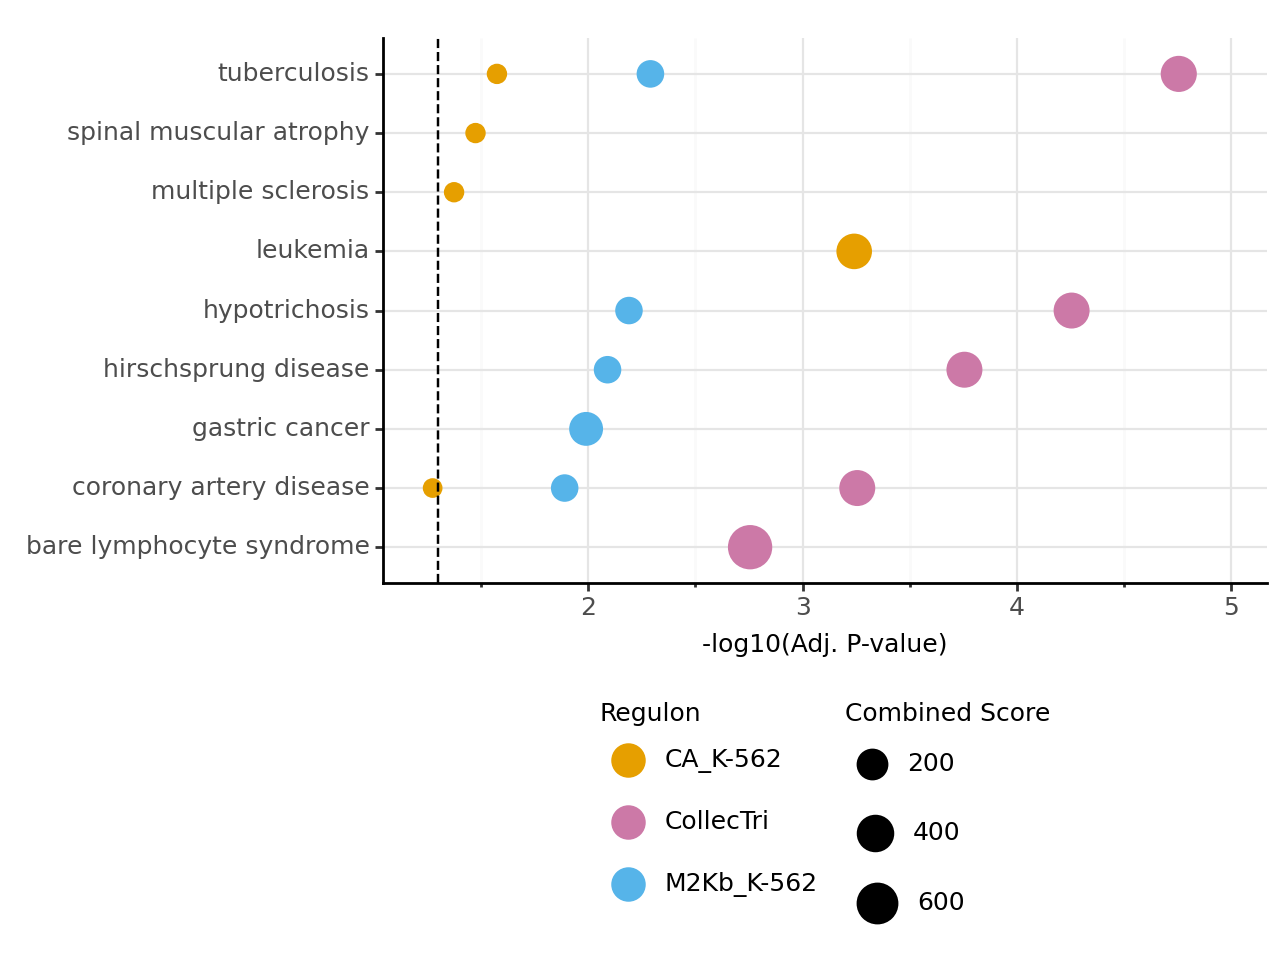

<Figure Size: (640 x 480)>

In [53]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [54]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,1.564497e-09,5.201306e-07,0.0,0.0,14.052601,351.512098,8.332747
std,2.643080e-09,7.090358e-07,0.0,0.0,4.505496,128.524337,2.944797
min,4.841542e-18,9.949369e-15,0.0,0.0,8.592960,204.624935,5.618045
25%,2.316425e-14,1.009445e-11,0.0,0.0,10.860959,275.684868,6.111828
50%,3.106398e-10,1.659613e-07,0.0,0.0,13.126494,298.273773,6.779993
75%,2.360278e-09,7.729861e-07,0.0,0.0,16.141118,436.946303,11.040639
max,9.615535e-09,2.409653e-06,0.0,0.0,23.218517,608.650334,14.002204


In [55]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,DisGeNET,Malignant neoplasm of lung,17/2449,3.106398e-10,3.892316e-07,0,0,13.624543,298.273773,ATF2;HDAC1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;RES...,M2Kb_K-562,6.409792
1,DisGeNET,Carcinogenesis,20/4065,8.894438e-10,5.572366e-07,0,0,13.126494,273.561702,ATF1;ATF2;HDAC1;PLAG1;CTCF;FOXM1;NR3C1;ETS1;PM...,M2Kb_K-562,6.253960
2,DisGeNET,Malignant neoplasm of ovary,15/2026,3.015175e-09,1.259338e-06,0,0,12.180507,238.976777,HDAC1;PLAG1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;KA...,M2Kb_K-562,5.899858
3,DisGeNET,Carcinoma of lung,16/2476,4.534318e-09,1.420375e-06,0,0,11.391220,218.843451,ATF2;HDAC1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;RES...,M2Kb_K-562,5.847597
4,DisGeNET,Ovarian Carcinoma,15/2203,9.615535e-09,2.409653e-06,0,0,11.084843,204.624935,HDAC1;PLAG1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;KA...,M2Kb_K-562,5.618045
0,DisGeNET,"Leukemia, Myelocytic, Acute",15/1703,8.115910e-12,1.262024e-08,0,0,23.218517,592.935797,CREBBP;SPI1;LEF1;IKZF1;GATA2;NR3C1;ELK1;KLF1;E...,CollecTri,7.898932
1,DisGeNET,leukemia,15/1941,5.343432e-11,4.154518e-08,0,0,20.084557,475.051353,CREBBP;SPI1;LEF1;NFATC3;IKZF1;GATA2;NR3C1;KLF1...,CollecTri,7.381479
2,DisGeNET,"Lupus Erythematosus, Systemic",12/1113,3.201825e-10,1.659613e-07,0,0,20.574387,449.799919,CREBBP;ELF1;SPI1;CREB1;SP1;IRF1;IRF2;CREM;IKZF...,CollecTri,6.779993
3,DisGeNET,Central neuroblastoma,13/1655,1.991299e-09,7.729861e-07,0,0,16.129923,323.154596,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri,6.111828
4,DisGeNET,Neuroblastoma,13/1698,2.729257e-09,7.729861e-07,0,0,15.681438,309.225975,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri,6.111828


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562.svg


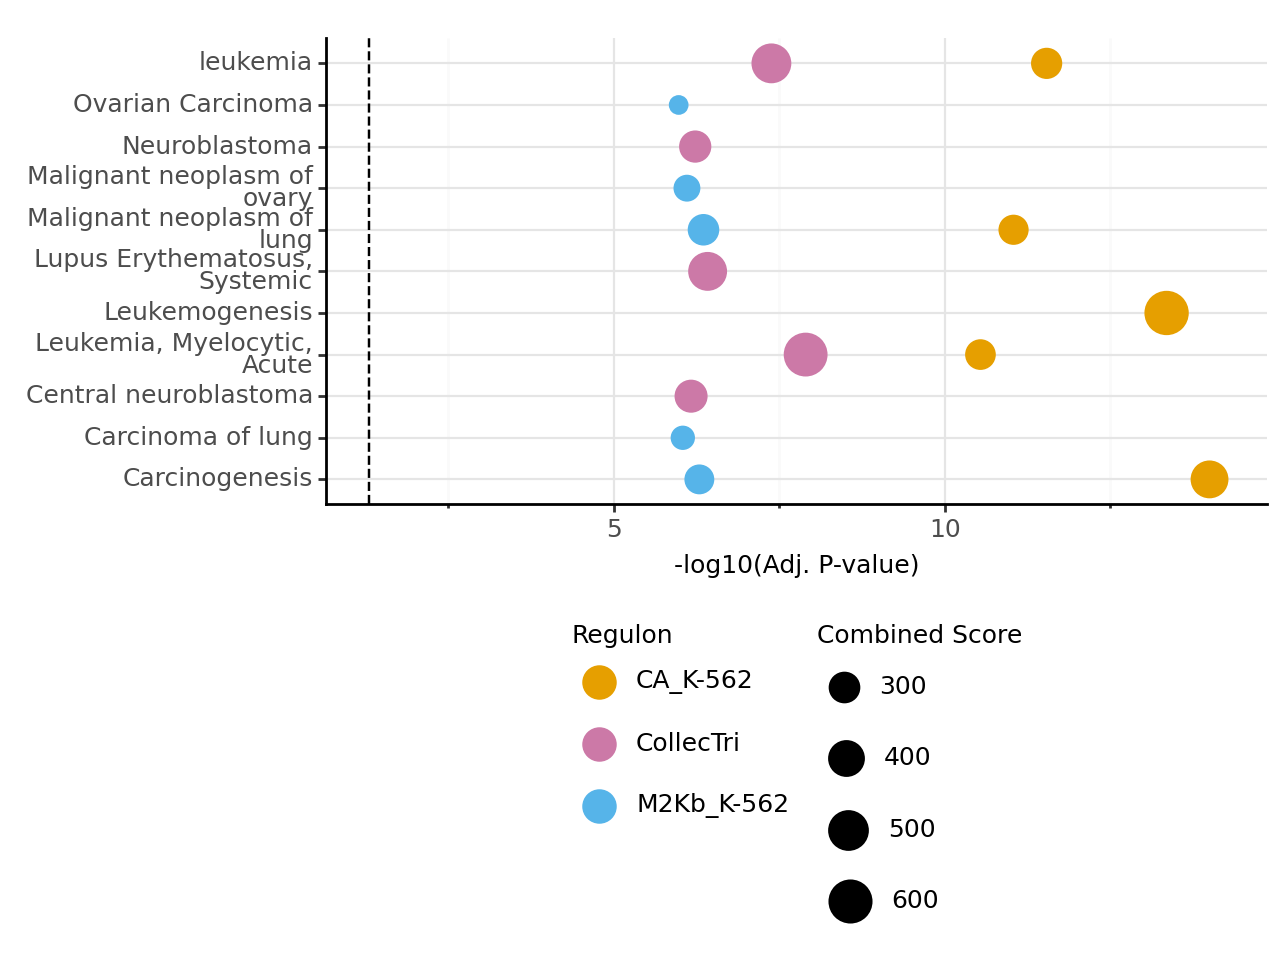

<Figure Size: (640 x 480)>

In [56]:
p = plot_enrich(aml_disreg_enrich, palette=okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [57]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.006643,0.023176,75.045864,487.490024,1.976619
std,0.008349,0.020399,37.392483,363.588664,0.753111
min,0.000150,0.001200,35.971429,237.640063,1.376127
25%,0.000167,0.002172,42.655172,348.832860,1.376127
50%,0.001352,0.028387,84.066667,348.832860,1.546885
75%,0.015773,0.042060,84.066667,370.967476,2.663069
max,0.015773,0.042060,128.469388,1131.176858,2.920886


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562.svg


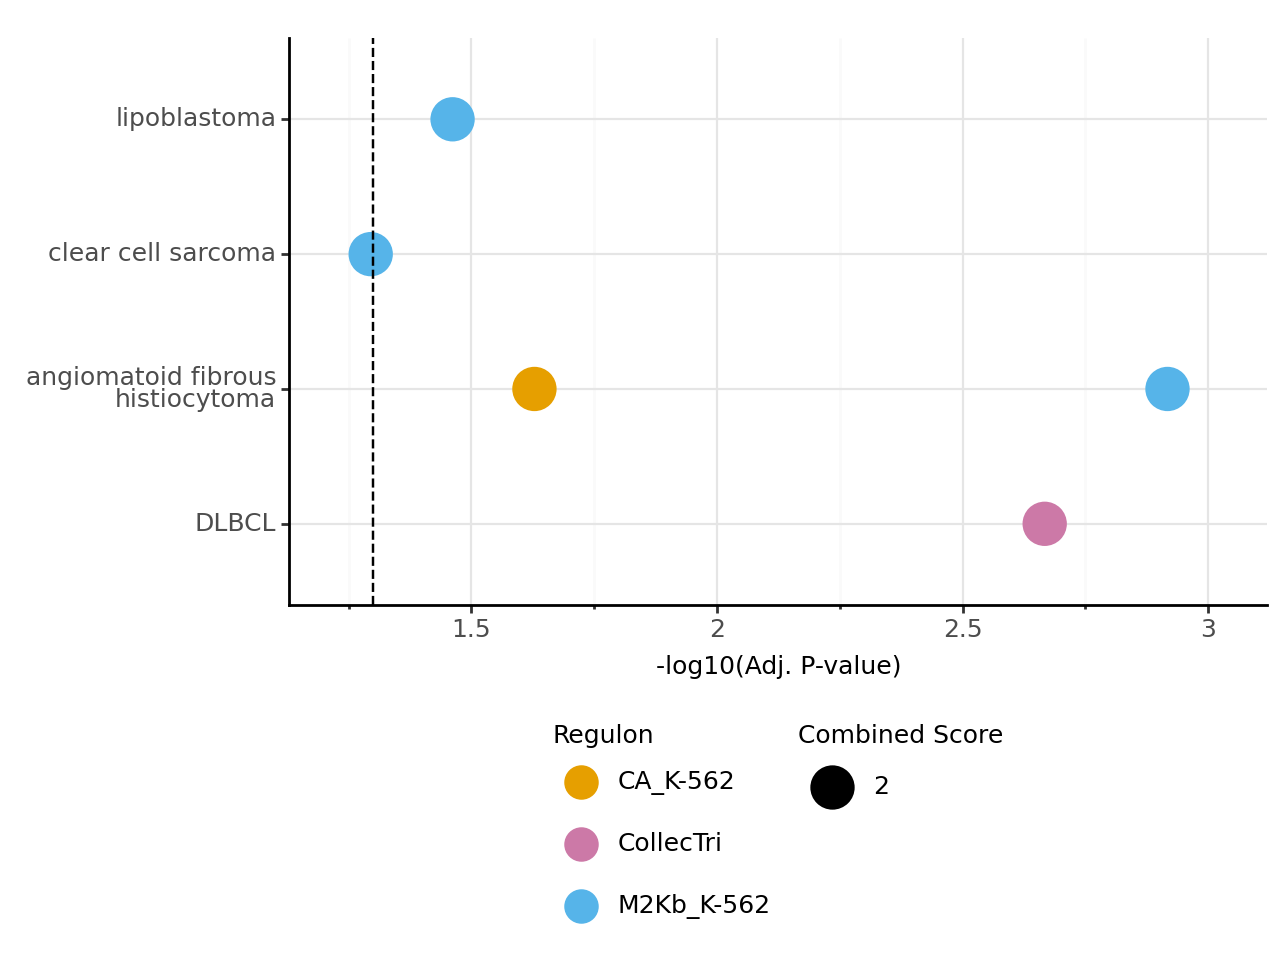

<Figure Size: (640 x 480)>

In [58]:
p = plot_enrich(aml_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [59]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.006643,0.023176,75.045864,487.490024,1.976619
std,0.008349,0.020399,37.392483,363.588664,0.753111
min,0.000150,0.001200,35.971429,237.640063,1.376127
25%,0.000167,0.002172,42.655172,348.832860,1.376127
50%,0.001352,0.028387,84.066667,348.832860,1.546885
75%,0.015773,0.042060,84.066667,370.967476,2.663069
max,0.015773,0.042060,128.469388,1131.176858,2.920886


In [60]:
megaheat.describe()

,score,p_value
count,628.000000,628.000000
mean,-0.620527,0.379280
std,1.273727,0.303456
min,-3.768019,0.000027
25%,-1.563516,0.089053
50%,-0.622352,0.328456
75%,0.247654,0.641937
max,4.202702,0.997168


In [61]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_hsc.tsv", sep="\t", index=False)

In [62]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [63]:
print(megaheat[megaheat.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score   p_value     Network       TF  log_p
PHF8    -2.682597  0.007343  M2Kb_K-562     PHF8    2.1
PLAG1   -2.665130  0.007735  M2Kb_K-562    PLAG1    2.1
CC2D1A  -2.640053  0.008330  M2Kb_K-562   CC2D1A    2.1
E2F1    -2.593962  0.009531  M2Kb_K-562     E2F1    2.0
TRIM28  -2.587372  0.009715  M2Kb_K-562   TRIM28    2.0
CREB1   -2.523240  0.011676  M2Kb_K-562    CREB1    1.9
ATF1    -2.483034  0.013078  M2Kb_K-562     ATF1    1.9
REST    -2.459150  0.013979  M2Kb_K-562     REST    1.9
SIN3A   -2.413681  0.015848  M2Kb_K-562    SIN3A    1.8
MNT     -2.408519  0.016074  M2Kb_K-562      MNT    1.8
ATF2    -2.395787  0.016642  M2Kb_K-562     ATF2    1.8
ZBTB7A  -2.339084  0.019393  M2Kb_K-562   ZBTB7A    1.7
SAP30   -2.318604  0.020480  M2Kb_K-562    SAP30    1.7
NFATC3  -2.263373  0.023680  M2Kb_K-562   NFATC3    1.6
BHLHE40 -2.262822  0.023714  M2Kb_K-562  BHLHE40    1.6
IRF1    -2.231071  0.025746  M2Kb_K-562     IRF1    1.6
GATA2   -2.193378  0.028352  M2Kb_K-562    GATA2

In [64]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

           score   p_value    Network      TF  log_p
EZH2   -2.955058  0.003149  CollecTri    EZH2    2.5
NFE2   -2.893968  0.003830  CollecTri    NFE2    2.4
NFIC   -2.653232  0.008012  CollecTri    NFIC    2.1
KLF1   -2.627798  0.008635  CollecTri    KLF1    2.1
E2F1   -2.590117  0.009638  CollecTri    E2F1    2.0
NFATC3 -2.573544  0.010111  CollecTri  NFATC3    2.0
CREB1  -2.501038  0.012433  CollecTri   CREB1    1.9
ELK1   -2.460927  0.013911  CollecTri    ELK1    1.9
GATA2  -2.048440  0.040599  CollecTri   GATA2    1.4
IRF2    2.034342  0.042000  CollecTri    IRF2    1.4
NR3C1   2.050395  0.040408  CollecTri   NR3C1    1.4
LEF1    2.165952  0.030389  CollecTri    LEF1    1.5
IKZF1   2.294379  0.021834  CollecTri   IKZF1    1.7
CREBBP  2.335270  0.019591  CollecTri  CREBBP    1.7
IRF1    2.360886  0.018291  CollecTri    IRF1    1.7
CTNNB1  2.487155  0.012928  CollecTri  CTNNB1    1.9
CREM    2.515737  0.011927  CollecTri    CREM    1.9
RFX5    2.920896  0.003515  CollecTri    RFX5 

In [65]:
megaheat

,score,p_value,Network,TF,log_p
UBTF,-3.768019,0.000168,CA_K-562,UBTF,3.8
ZNF148,-3.392079,0.000702,CA_K-562,ZNF148,3.2
FOXJ2,-3.386021,0.000718,CA_K-562,FOXJ2,3.1
RREB1,-3.356646,0.000798,CA_K-562,RREB1,3.1
YY1,-3.353904,0.000806,CA_K-562,YY1,3.1
...,...,...,...,...,...
RFX5,2.920896,0.003515,CollecTri,RFX5,2.5
HEY1,3.339543,0.000849,CollecTri,HEY1,3.1
SP1,3.776416,0.000162,CollecTri,SP1,3.8
ELF1,3.954784,0.000078,CollecTri,ELF1,4.1


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


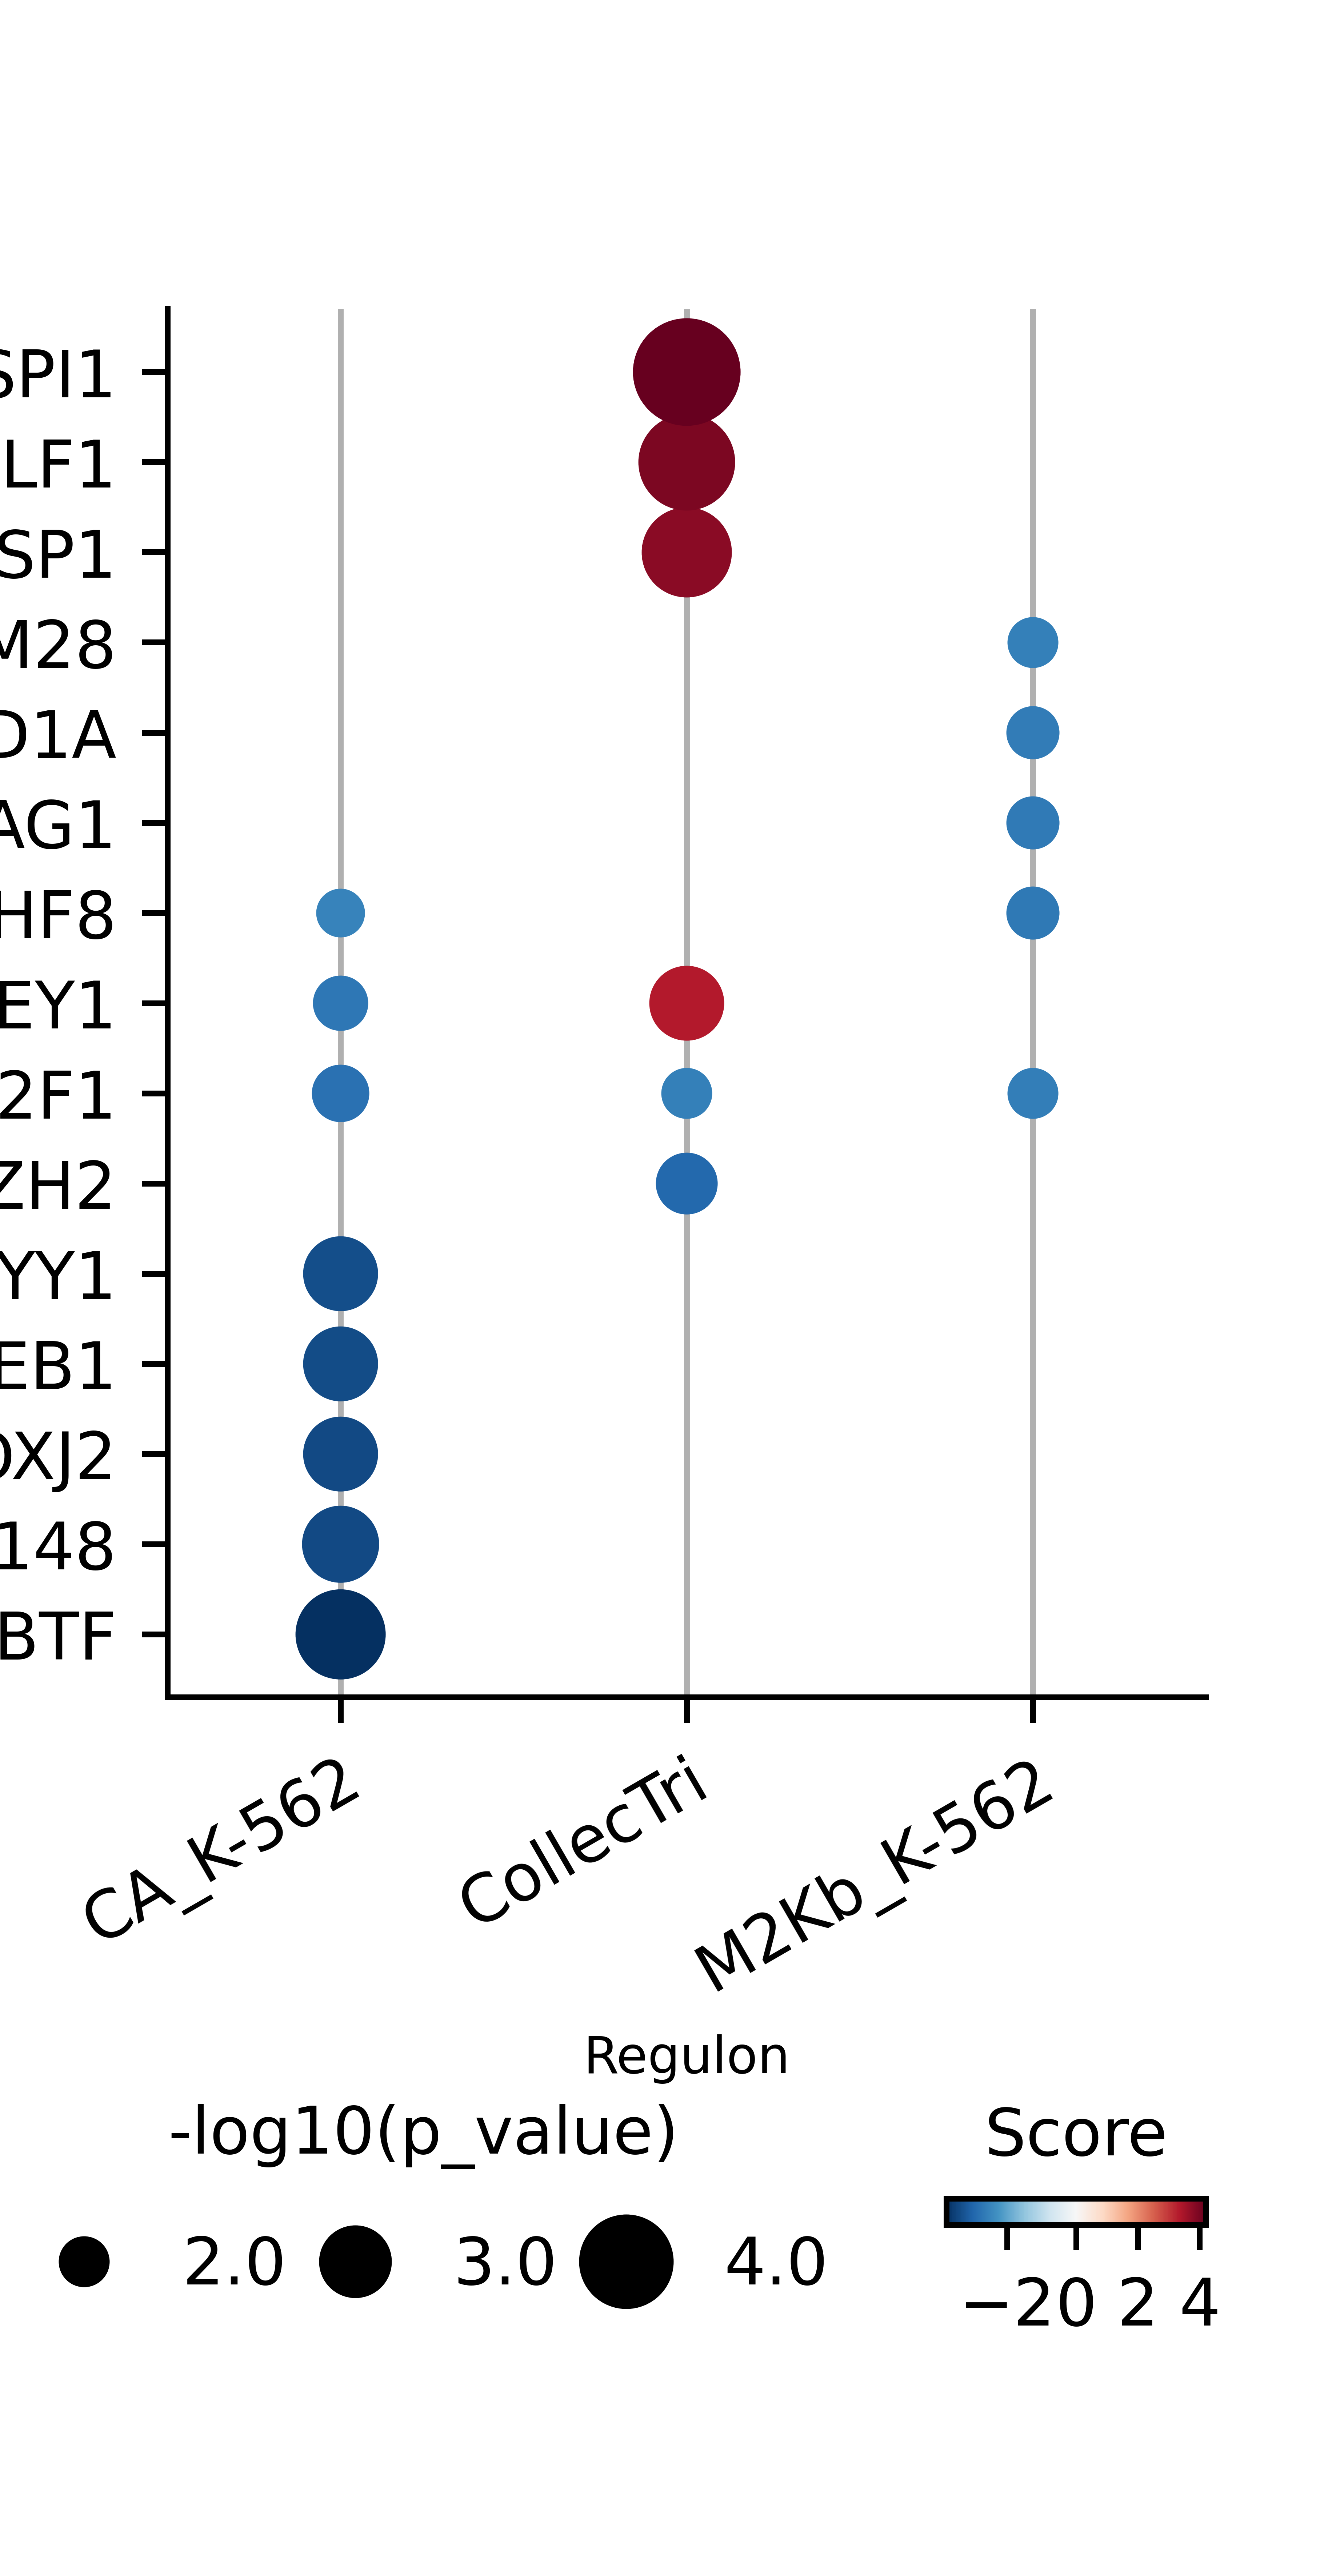

In [66]:
plt.close()
out = pd.DataFrame()
interesting_tf = []
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out, scale=0.5)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_hsc_k562.svg", dpi=720, format="svg")
plt.show()

In [67]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list()))

In [68]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

EZH2, NFE2, NFIC, KLF1, E2F1, NFATC3, CREB1, ELK1, GATA2, IRF2, NR3C1, LEF1, IKZF1, CREBBP, IRF1, CTNNB1, CREM, RFX5, HEY1, SP1, ELF1, SPI1


In [69]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(5))
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_hsc.tsv", sep="\t", index=False)

          Gene_set                                             Term Overlap  \
0  KEGG_2021_Human  Kaposi sarcoma-associated herpesvirus infection   6/193   
1  KEGG_2021_Human                               Pathways in cancer   8/531   
2  KEGG_2021_Human                                  Prostate cancer    5/97   
3  KEGG_2021_Human          Human T-cell leukemia virus 1 infection   6/219   
4  KEGG_2021_Human                  Human cytomegalovirus infection   6/225   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  4.901047e-08          0.000002            0                     0   
1  5.396104e-08          0.000002            0                     0   
2  5.964251e-08          0.000002            0                     0   
3  1.037294e-07          0.000003            0                     0   
4  1.217140e-07          0.000003            0                     0   

   Odds Ratio  Combined Score                                       Genes  
0   39.687834   

In [70]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(5))
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)

          Gene_set                                     Term Overlap  \
0  KEGG_2021_Human  Human T-cell leukemia virus 1 infection   6/219   
1  KEGG_2021_Human                      Cellular senescence   4/156   
2  KEGG_2021_Human                              Hepatitis B   4/162   
3  KEGG_2021_Human                    Amphetamine addiction    3/69   
4  KEGG_2021_Human  Transcriptional misregulation in cancer   4/192   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  3.085767e-07          0.000027            0                     0   
1  4.657479e-05          0.001565            0                     0   
2  5.395666e-05          0.001565            0                     0   
3  9.652527e-05          0.001607            0                     0   
4  1.042939e-04          0.001607            0                     0   

   Odds Ratio  Combined Score                              Genes  
0   27.832394      417.243649  KAT2B;ATF2;CREB1;NFATC3;E2F1;ETS1  
1   23